In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression as AI
from sklearn.metrics import brier_score_loss, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier


import imageio

import os
os.environ['KERAS_BACKEND'] = 'tensorflow' 
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/dot.exe'
import keras
from keras import Sequential
from keras.layers import Dense

import graphviz

Using TensorFlow backend.


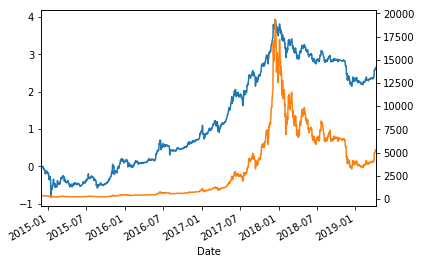

In [18]:
df_btc = pd.read_csv('data/BTC-USD.csv', parse_dates= ['Date'], index_col='Date', usecols=['Date', 'Adj Close'])
df_btc = df_btc.groupby('Date').mean()
df_btc.columns = ['BTC']

df_vcrix = pd.read_csv('data/new_vcrix',parse_dates= ['Date'], index_col='Date', usecols=['Date', 'vola', 'vcrix'])

df_test = pd.concat([df_btc, df_vcrix], sort=True, axis=1).dropna()
dr_vars = []
for var in ['BTC']:
    dr = "dr_" + var
    dr_vars.append(dr)
    df_test[dr]=np.log(df_test[var]) #log daily return line 1
    df_test[dr]=df_test[dr].diff().fillna(0) #log daily return line 2
    
df_test.dr_BTC.cumsum().plot()
df_test.BTC.plot(secondary_y=True)
plt.show()
# df_test.vcrix.cumsum().plot()
# df_test.vola.plot(secondary_y=True)
# plt.show()


#shift btc into the past
df_test.dr_BTC = df_test.dr_BTC.shift(1).fillna(method='ffill')
df_test.BTC = df_test.BTC.shift(1).fillna(method='ffill')

#indicators
window_size = 7
df_test['d'+str(window_size)+'_mean'] = df_test.BTC.rolling(window=window_size, min_periods=0).mean()
df_test['d'+str(window_size)+'gain_ratio']  = (df_test.BTC / df_test['d'+str(window_size)+'_mean'])-1

#make target
df_test['target'] = np.where(df_test.dr_BTC>0, 1, 0)

df_test = df_test.fillna(method='ffill').fillna(0)

0.7452941950770041
0.6789940828402367
0.20781272569893855


C:\Users\justi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


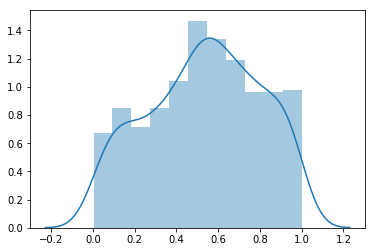

In [25]:
test_cutoff = '2016-06-01'
X = df_test.copy().drop(['dr_BTC', 'BTC', 'target', 'vola', 'd7_mean'], axis=1)
X_train = X.loc[:test_cutoff].values
X_test = X.loc[test_cutoff:].values
y = df_test['target']
y_train = y.loc[:test_cutoff].values
y_test = y.loc[test_cutoff:].values

df_btc = df_test.loc[test_cutoff:].BTC
btc_dr = np.log(df_btc) #log daily return line 1
btc_dr=btc_dr.diff().fillna(0) #log daily return line 2

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

logit = AI(solver = 'lbfgs', fit_intercept=True, C=100, max_iter=1000)
# logit = DecisionTreeClassifier(max_depth=10, min_samples_leaf=50)
# logit = KNeighborsClassifier(n_neighbors=50)
logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)[:,1]
logit_pred_discrete = np.where(logit_pred>0.45,1,0)#logit.predict(X_test)
print(roc_auc_score(y_test, logit_pred))
print(accuracy_score(y_test, logit_pred_discrete))
print(brier_score_loss(y_test, logit_pred))
sns.distplot(logit_pred)

Strategy:       7.1415396819078145
Staying in BTC: 0.7681828690072479


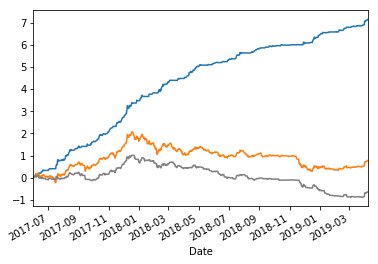

In [27]:
logit_pred_discrete = np.where(logit_pred>0.5,1,0)
returns_discrete = (logit_pred_discrete * btc_dr).cumsum()
returns_naive = btc_dr.cumsum()
returns_perfect = (pd.Series(y_test).shift(-1).fillna(0).values * btc_dr).cumsum()
print('Strategy:       {}\nStaying in BTC: {}'.format(returns_discrete[-1], returns_naive[-1]))
returns_discrete.plot()
returns_naive.plot()
# returns_perfect.plot(c='grey')

In [22]:
print(logit.coef_, logit.intercept_)
print(X.columns)

[[-0.0232431   1.25596229]] [-0.24873365]
Index(['vcrix', 'd7gain_ratio'], dtype='object')


In [7]:
# xx, yy = np.mgrid[-3:3:.01, -6:6:.01]
# grid = np.c_[xx.ravel(), yy.ravel()]
# probs = logit.predict_proba(grid)[:, 1].reshape(xx.shape)
# fig, ax = plt.subplots(figsize=(8, 6))
# contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
#                       vmin=0, vmax=1, alpha=1)
# ax_c = fig.colorbar(contour)
# ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])

# ax.scatter(X_test[:,0], X_test[:, 1], c=y_test[:], s=25,
#            cmap='binary', vmin=-.2, vmax=1.2,
#            edgecolor=None, linewidth=1)

# ax.set(xlim=(-2, 2.5), ylim=(-3, 3),
#        xlabel="$X_1$", ylabel="$X_2$")

# plt.show()